In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim


import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
from src.TraPredModel import TraPredModel

In [2]:
import torch.utils
import torch.utils.data


lookback = 20
dir = '../data/PandasData/Sampled/'
ds = MyDataset(lookback=lookback)

def process_data(df_dir : str, target_freq : int = 10):
    df: pd.DataFrame = pd.read_pickle(df_dir)
    df.dropna(inplace=True, how='any')
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    if f_per_sec < target_freq:
        raise ValueError('The frequency of the data is lower than the target frequency')
    elif int(f_per_sec) == target_freq:
        pass
    else:
        resample_ratio = int(f_per_sec/target_freq)
        df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget']:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)


In [3]:

stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data()

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader
train, test = ds.split_data(frac=0.9, shuffle=True, batch_size=4)


feature_dim = ds.feature_dim
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/notebook/../src/MyDataset.py:101: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X), torch.tensor(y)


columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'start_station_X', 'start_station_Y', 'end_station_X',
       'end_station_Y', 'distance_from_start_station_X',
       'distance_from_start_station_Y', 'distance_from_end_station_X',
       'distance_from_end_station_Y', 'facing_start_station',
       'facing_end_station', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'AGV_name',
       'looking_at_closest_station', 'rolling_avg'],
      dtype='object') 
feature_dim : 32


In [4]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train), len(test))

torch.Size([4, 20, 32]) torch.Size([4, 20, 32])
20562 2285


In [5]:
model = TraPredModel(input_size=feature_dim, lookback=lookback, hidden_size=128, bidirectional=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

loss_fn = nn.MSELoss()

for name, param in model.named_parameters():
    if 'weight_ih' in name:  # input-hidden weights in LSTM cells
        torch.nn.init.xavier_uniform_(param.data)
    elif 'weight_hh' in name:  # hidden-hidden weights
        torch.nn.init.orthogonal_(param.data)
    elif 'bias' in name:  # biases
        param.data.fill_(0)
    elif 'weight' in name:  # linear layers weights
        if param.dim() >= 2:  # Only apply to weights with 2 or more dimensions
            torch.nn.init.kaiming_normal_(param.data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")
model.to(device)


Using cuda


TraPredModel(
  (lstm): LSTM(32, 128, num_layers=20, batch_first=True, dropout=0.1, bidirectional=True)
  (mlp): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=32, bias=True)
  )
)

In [7]:
n_epochs = 1
eval_step = 3000
# model = TraPredModel(input_size=numeric_df.shape[1], lookback=lookback)

train_all = len(train)

loss_all = []

for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total = train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = torch.mean(loss_fn(y_pred, y_batch[:, :1, :].squeeze(1)))
        if torch.isnan(loss):
            print("Loss is NaN")
            continue
        loss_all.append(loss.item())
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Validation
        if (epoch * train_all + step + 1) % eval_step == 0:
            print(f"Start testing")
            with torch.no_grad():
                model.eval()
                all_test = len(test)
                test_rmse_all = []
                for X_test_batch, y_test_batch in tqdm(test):
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    y_pred = model(X_test_batch)
                    test_rmse = torch.mean(loss_fn(y_pred, y_test_batch[:, :1, :]))
                    test_rmse = torch.sqrt(test_rmse)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())

                print("Epoch %d: test RMSE %.4f" % (epoch+1, sum(test_rmse_all)/all_test))
            
            model.train()
        



  0%|          | 0/20562 [00:00<?, ?it/s]

Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

/home/shaoze/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 32])) that is different to the input size (torch.Size([4, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/shaoze/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 32])) that is different to the input size (torch.Size([3, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: test RMSE 0.2461
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2430
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2434
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2436
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2430
Start testing


  0%|          | 0/2285 [00:00<?, ?it/s]

Epoch 1: test RMSE 0.2431


<Axes: title={'center': 'Loss'}>

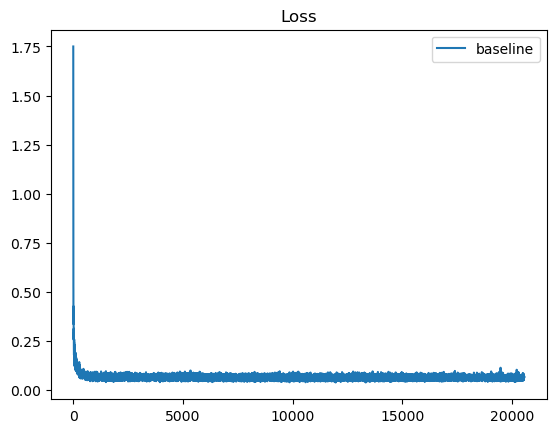

In [9]:
# df = pd.DataFrame({'baseline': loss_all}) #, 'state': loss_state
# df.plot(title='Loss')

In [47]:
loss_np = np.sqrt(np.array(loss_all))
np.save('../model/loss_baseline.npy', loss_np)